## Importing Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_excel("dataset.xlsx")
data

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,ae66feb9e4dc3a0,3,positive,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,517c2834024f3ea,17,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,5c57d6037fe266d,4,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,c20c44766f28291,10,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature engineering

In [4]:
data.columns = [x.lower().strip().replace(' ','_') for x in data.columns]

def miss_data(x):
    total = x.isnull().sum()
    percent = (x.isnull().sum()/x.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(x[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [5]:
for x in data.columns:
    if data[x].dtype=='float16' or  data[x].dtype=='float32' or  data[x].dtype=='float64':
        data[x].fillna(data[x].mean())

data = data.fillna(data.median())

for y in data.columns:
    if data[y].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(data[y].values))
        data[y] = lbl.transform(list(data[y].values))

In [6]:
threshold = 0.92

corr_matrix = data.corr().abs()


upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [7]:
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))
dataset = data.drop(columns = to_drop)

There are 23 columns to remove.


In [8]:
data_missing = (data.isnull().sum() / len(data)).sort_values(ascending = False)
data_missing.head()

urine_-_sugar                        1.0
mycoplasma_pneumoniae                1.0
partial_thromboplastin_time (ptt)    1.0
d-dimer                              1.0
prothrombin_time_(pt),_activity      1.0
dtype: float64

In [9]:
data_missing_ = data_missing.index[data_missing > 0.85]
all_missing = list(set(data_missing_))


dataset = dataset.drop(columns = all_missing)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Data columns (total 83 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   patient_id                                             5644 non-null   int32  
 1   patient_age_quantile                                   5644 non-null   int64  
 2   sars-cov-2_exam_result                                 5644 non-null   int32  
 3   patient_addmited_to_regular_ward_(1=yes,_0=no)         5644 non-null   int64  
 4   patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)  5644 non-null   int64  
 5   patient_addmited_to_intensive_care_unit_(1=yes,_0=no)  5644 non-null   int64  
 6   hematocrit                                             5644 non-null   float64
 7   platelets                                              5644 non-null   float64
 8   mean_platelet_volume                            

In [10]:
cols = [x for x in dataset.columns if x not in ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']]
new_df = dataset[cols]
new_df.head()

,patient_age_quantile,hematocrit,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration (mchc),leukocytes,basophils,mean_corpuscular_hemoglobin_(mch),...,lipase_dosage,albumin,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
0,13,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903,...,-0.350655,-0.03849,0.267769,-0.21208,-0.011817,0.077435,-0.159955,-0.011744,-0.138182,0.182693
1,17,0.236515,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,...,-0.350655,-0.03849,0.267769,-0.21208,-0.011817,0.077435,-0.159955,-0.011744,-0.138182,0.182693
2,8,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903,...,-0.350655,-0.03849,0.267769,-0.21208,-0.011817,0.077435,-0.159955,-0.011744,-0.138182,0.182693
3,5,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903,...,-0.350655,-0.03849,0.267769,-0.21208,-0.011817,0.077435,-0.159955,-0.011744,-0.138182,0.182693
4,15,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903,...,-0.350655,-0.03849,0.267769,-0.21208,-0.011817,0.077435,-0.159955,-0.011744,-0.138182,0.182693


In [11]:
X = new_df
y = dataset['sars-cov-2_exam_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=101)

[2.04374115e-01 1.83625541e-02 3.53293763e-02 1.92231980e-02
 2.14802443e-02 1.88022395e-02 1.59703013e-02 5.07979191e-02
 1.84771272e-02 1.74038854e-02 2.15516731e-02 1.78520134e-02
 3.81109887e-02 1.61055002e-02 9.04944835e-03 7.09640459e-03
 6.56338063e-03 1.08984555e-02 1.11362390e-02 2.24715220e-02
 1.13218522e-02 1.70933469e-02 1.53947958e-02 2.80953347e-02
 1.55323341e-02 1.27463247e-02 1.14892108e-02 2.63763788e-02
 1.14815614e-02 1.46751234e-02 1.27545148e-02 9.15279788e-03
 8.64293920e-03 9.08708737e-03 7.31875240e-03 4.10362606e-03
 1.89290689e-02 1.56143041e-03 6.16001028e-03 5.34799112e-03
 5.12919814e-03 4.03777373e-03 0.00000000e+00 4.78784758e-03
 5.75058885e-03 5.70184172e-03 4.96329875e-03 1.26724069e-06
 3.53531520e-04 3.06067553e-05 0.00000000e+00 3.06170070e-03
 4.09932457e-03 7.94713775e-03 2.47317696e-03 2.60077532e-03
 1.57969197e-06 5.24358600e-03 6.41818508e-03 4.49802182e-03
 2.41386890e-03 7.53734333e-03 5.67619172e-03 1.80699774e-02
 9.40389801e-05 9.582587

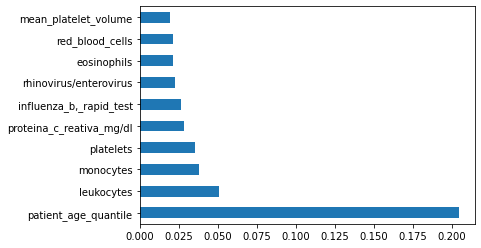

Index(['patient_age_quantile', 'hematocrit', 'platelets',
       'mean_platelet_volume', 'red_blood_cells', 'lymphocytes',
       'mean_corpuscular_hemoglobin_concentration (mchc)', 'leukocytes',
       'basophils', 'mean_corpuscular_hemoglobin_(mch)'],
      dtype='object')

In [12]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

feat_head = feat_importances.head(10)
feat_head.index

## Model to give covid result

In [13]:
newdf = new_df[feat_head.index]

X = newdf
y = dataset['sars-cov-2_exam_result']
X

,patient_age_quantile,hematocrit,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration (mchc),leukocytes,basophils,mean_corpuscular_hemoglobin_(mch)
0,13,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903
1,17,0.236515,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269
2,8,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903
3,5,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903
4,15,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903
...,...,...,...,...,...,...,...,...,...,...
5639,3,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903
5640,17,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903
5641,4,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903
5642,10,0.053407,-0.121716,-0.101517,0.013852,-0.014267,-0.054585,-0.212879,-0.223767,0.125903


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 101)

In [15]:
accuracy_lst =[]

def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    prds = model.predict(X_test)
    model_acc = accuracy_score(y_test, prds)
    accuracy_lst.append(100*model_acc)
    print('---', name, '---', '\n',
          confusion_matrix(y_test, prds), '\n',
          'Accuracy:', (accuracy_score(y_test, prds)), '\n',
          'Classification Report:', (classification_report(y_test, prds)))
    

In [16]:
# Logistic Regression
lg = LogisticRegression()
model_assess(lg, 'Logistic Regression')
lg.fit(X_train,y_train)

# SVM
svm = SVC()
model_assess(svm, 'SVM')
svm.fit(X_train,y_train)

--- Logistic Regression --- 
 [[1683    4]
 [ 170    6]] 
 Accuracy: 0.9066022544283414 
 Classification Report:               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1687
           1       0.60      0.03      0.06       176

    accuracy                           0.91      1863
   macro avg       0.75      0.52      0.51      1863
weighted avg       0.88      0.91      0.87      1863

--- SVM --- 
 [[1687    0]
 [ 176    0]] 
 Accuracy: 0.90552871712292 
 Classification Report:               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1687
           1       0.00      0.00      0.00       176

    accuracy                           0.91      1863
   macro avg       0.45      0.50      0.48      1863
weighted avg       0.82      0.91      0.86      1863



SVC()

In [17]:
cross_acc = []

ca_lg = cross_val_score(lg, X_train, y_train, scoring='accuracy')
ca_lg = ca_lg.mean()
cross_acc.append(100*ca_lg)



ca_svm = cross_val_score(svm, X_train, y_train, scoring='accuracy')
ca_svm = ca_svm.mean()
cross_acc.append(100*ca_svm)

## Admisiion to ward if patient covid positive: model of interest

### 0- no need to hospitialze, 1-general, 2 -icu

In [18]:
covid_positive = dataset[dataset['sars-cov-2_exam_result'] == 1]

admission = []  

def multiclass_target(row):
    check = 0
    check += 1 if (row['patient_addmited_to_regular_ward_(1=yes,_0=no)'] == 1) else 0
    check += 2 if (row['patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)'] == 1) else 0
    check += 2 if (row['patient_addmited_to_intensive_care_unit_(1=yes,_0=no)'] == 1) else 0
    row['target'] = check
    return row

In [19]:
data_adm = covid_positive.apply(multiclass_target, axis=1)
data_adm.rename(columns = {'mean_corpuscular_hemoglobin_concentration': 'mchc','mean_corpuscular_hemoglobin_(mch)' : 'mch'},inplace= True)
data_adm

admit = data_adm[['patient_age_quantile','hematocrit','platelets',  'proteina_c_reativa_mg/dl', 'red_blood_cells', 'eosinophils','leukocytes', 'monocytes','influenza_b,_rapid_test'] ]
X=admit
y = data_adm['target']

admit

,patient_age_quantile,hematocrit,platelets,proteina_c_reativa_mg/dl,red_blood_cells,eosinophils,leukocytes,monocytes,"influenza_b,_rapid_test"
67,7.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
284,16.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
513,10.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
568,2.0,0.991838,-0.341548,-0.394284,1.653476,-0.498393,-0.420197,1.933339,0.0
676,15.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
...,...,...,...,...,...,...,...,...,...
5632,16.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
5633,4.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
5634,15.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
5639,3.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [21]:
acc_lst = []

def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    prds = model.predict(X_test)
    model_acc = accuracy_score(y_test, prds)
    acc_lst.append(100*model_acc)
    print('---', name, '---', '\n',
          confusion_matrix(y_test, prds), '\n',
          'Accuracy:', (accuracy_score(y_test, prds)), '\n',
          'Classification Report:', (classification_report(y_test, prds)))

In [22]:
lg = LogisticRegression()
model_assess(lg, 'Logistic Regression')
lg.fit(X_train, y_train)

--- Logistic Regression --- 
 [[101   1   0]
 [  7   0   1]
 [  1   0   1]] 
 Accuracy: 0.9107142857142857 
 Classification Report:               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       102
         1.0       0.00      0.00      0.00         8
         2.0       0.50      0.50      0.50         2

    accuracy                           0.91       112
   macro avg       0.48      0.50      0.49       112
weighted avg       0.85      0.91      0.88       112



LogisticRegression()

### order of entering the values should be asper order of columns in admit table

In [32]:
X_test

,patient_age_quantile,hematocrit,platelets,proteina_c_reativa_mg/dl,red_blood_cells,eosinophils,leukocytes,monocytes,"influenza_b,_rapid_test"
5260,19.0,-0.518807,-1.321369,1.622533,-0.567950,-0.751229,-1.007366,-0.036401,0.0
5306,4.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
5146,18.0,0.968950,-0.504851,-0.328713,1.089304,-0.709090,-1.160420,0.226231,0.0
5090,18.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
4582,7.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
...,...,...,...,...,...,...,...,...,...
5576,9.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
5600,9.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
5591,12.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,0.0
4502,8.0,0.053407,-0.121716,-0.394284,0.013852,-0.329835,-0.212879,-0.115191,1.0


In [34]:
lg.predict([[19, -0.51, -1.32, 1.62, -0.56, -0.75, -1.007, -0.03,0] ])

array([2.])

In [24]:
lg.predict(X_test)

array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])